<a href="https://colab.research.google.com/github/swerchansky/optimization-methods/blob/main/2_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import cProfile, pstats, tracemalloc, linecache, os
from matplotlib import cm
from time import time
from random import shuffle
from math import exp

# 1 пункт

## loss function

In [4]:
def loss_function(X, Y, theta):
    return (Y - X@theta).T@(Y - X@theta)

## Profiling

In [118]:
def profile(call, stat_filename) :
    tracemalloc.start()

    prof = cProfile.Profile()
    snapBefore = tracemalloc.take_snapshot()
    prof.enable()
    call_data = call() # start computation to profile 
    prof.disable()
    tracemalloc.stop()

    stats = pstats.Stats(prof)
    stats.dump_stats(stat_filename + ".profile")

    mem_diff = call_data["snap"].compare_to(snapBefore, 'lineno')
    total = sum(stat.size_diff for stat in mem_diff)
    print("Total allocated size: %.1f KiB" % (total / 1024))

    call_data.update({'mem' : total / 1024, 'time' : stats.get_stats_profile().total_tt})
    return call_data

## SGD

In [119]:
def stochastic_descent(X, Y, coefficients, lr=0.1, eps=1e-4):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    points = [coefficients]
    previous_cost = 10 ** 6
    current_cost = loss_function(X, Y, theta)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        i = np.random.randint(0, len(Y))
        derivatives = [0] * len(theta)
        for j in range(len(theta)):
            derivatives[j] = (Y[i] - X[i]@theta) * X[i][j]
        theta[0] += lr * derivatives[0]
        theta[1] += lr * derivatives[1]
        current_cost = loss_function(X, Y, theta)
        points.append(theta.copy())
        epoch += 1

    snap = tracemalloc.take_snapshot()
    print(current_cost, epoch, "sgd_cost", "epoch_count")
    return {'pt' : points, 'cost' : current_cost, 'iter' : epoch, 'snap' : snap}

## Minibatch GD


In [120]:
def minibatch_descent(X, Y, coefficients, batch_size=10, lr=0.1, eps=1e-4):
    theta = coefficients.copy()
    points = [coefficients]
    previous_cost = 10 ** 6
    current_cost = loss_function(X, Y, theta)
    epoch = 1
    indicies = [x for x in range(0, len(Y))]
    shuffle(indicies)
    while np.abs(previous_cost - current_cost) > eps:
        if epoch % batch_size == 0:
          shuffle(indicies)
        previous_cost = current_cost
        derivatives = [0] * len(theta)
        for j in range(len(theta)):
            summ = 0
            for i in range(batch_size):
                summ += (Y[indicies[(epoch * batch_size + i) % len(Y)]] - X[indicies[(epoch * batch_size + i) % len(Y)]]@theta) * X[indicies[(epoch * batch_size + i) % len(Y)]][j]
            derivatives[j] = summ
        theta[0] += lr * derivatives[0] / batch_size
        theta[1] += lr * derivatives[1] / batch_size
        current_cost = loss_function(X, Y, theta)
        points.append(theta.copy())
        epoch += 1

    snap = tracemalloc.take_snapshot()
    print(current_cost, epoch, "minibatch_cost", "epoch_count")
    return {'pt' : points, 'cost' : current_cost, 'iter' : epoch, 'snap' : snap}

## GD

In [121]:
def batch_descent(X, Y, coefficients, lr=0.001, eps=1e-4):
    theta = coefficients.copy()
    points = [coefficients]
    previous_cost = 10 ** 6
    current_cost = loss_function(X, Y, theta)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        derivatives = [0] * len(theta)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ += (Y[i] - X[i]@theta) * X[i][j]
            derivatives[j] = summ
        theta[0] += lr * derivatives[0] / len(Y)
        theta[1] += lr * derivatives[1] / len(Y)
        current_cost = loss_function(X, Y, theta)
        points.append(theta.copy())
        epoch += 1

    snap = tracemalloc.take_snapshot()
    print(current_cost, epoch, "gd_cost", "epoch_count")
    return {'pt' : points, 'cost' : current_cost, 'iter' : epoch, 'snap' : snap}

## Testing

262.35152642015504 6123 sgd_cost epoch_count
Total allocated size: 821.0 KiB
266.97403590810916 487 minibatch_cost epoch_count
Total allocated size: 63.2 KiB
262.5858491155739 1817 minibatch_cost epoch_count
Total allocated size: 233.0 KiB
263.418229537354 1127 minibatch_cost epoch_count
Total allocated size: 145.9 KiB
263.19528812308903 1235 minibatch_cost epoch_count
Total allocated size: 158.5 KiB
262.355984203938 3654 gd_cost epoch_count
Total allocated size: 458.2 KiB


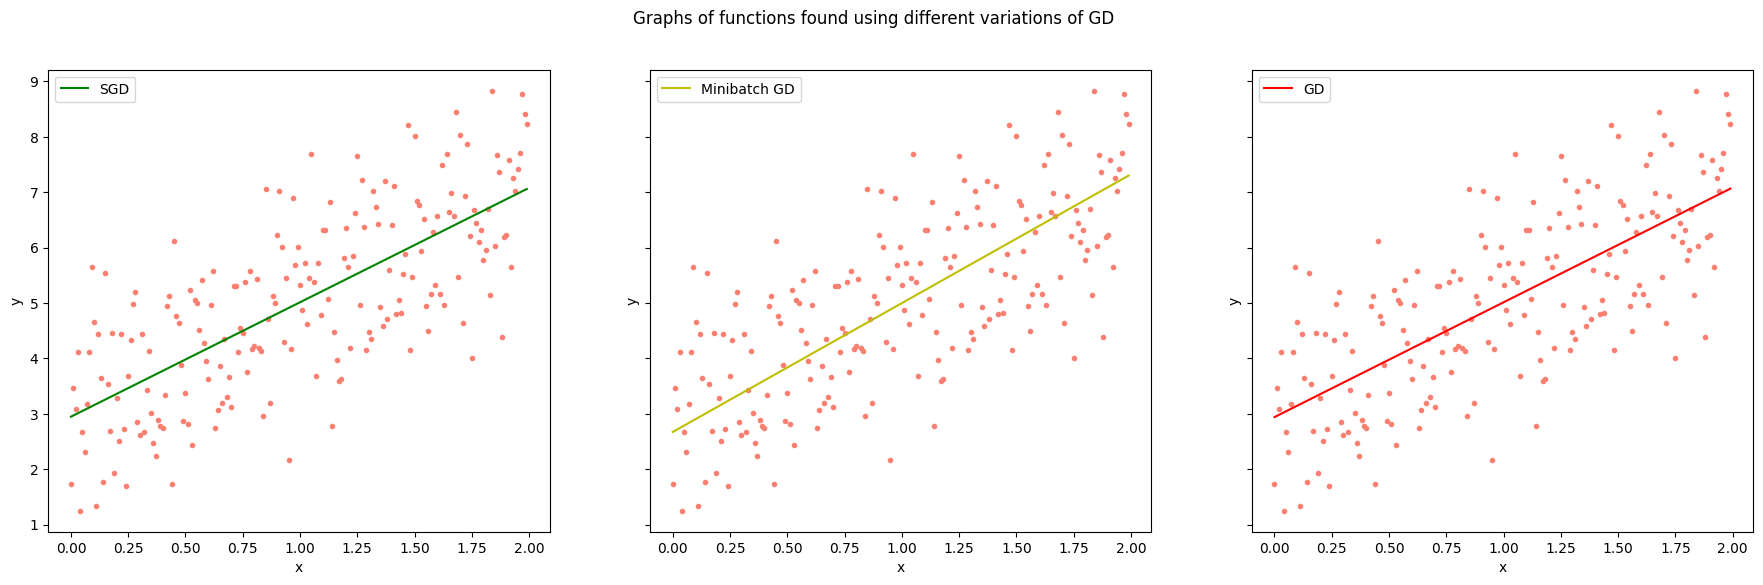

/tmp/ipykernel_1761/3515849350.py:25: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = dist


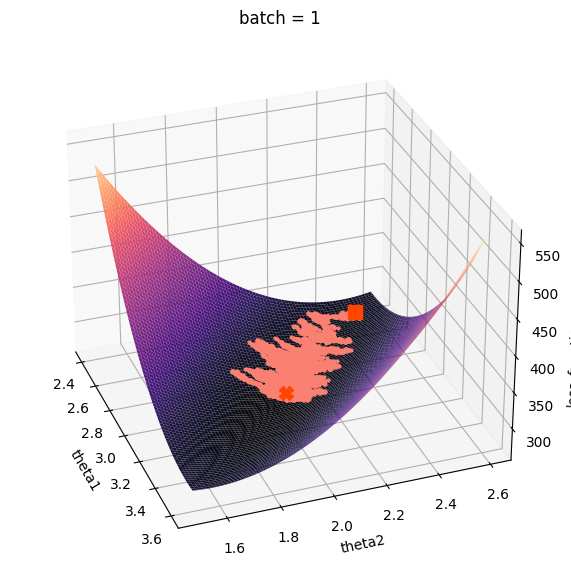

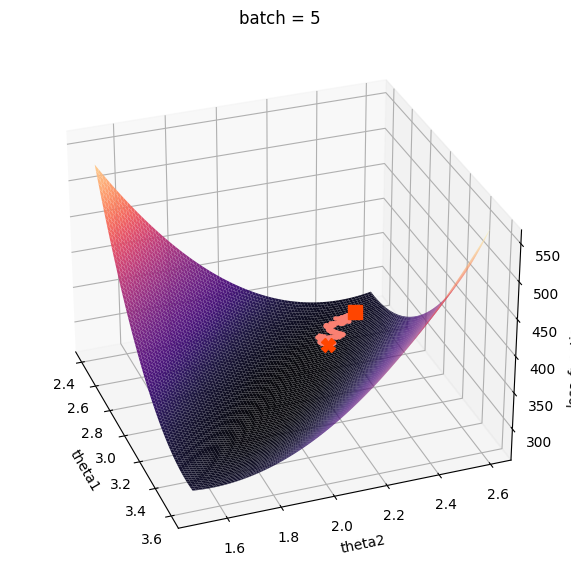

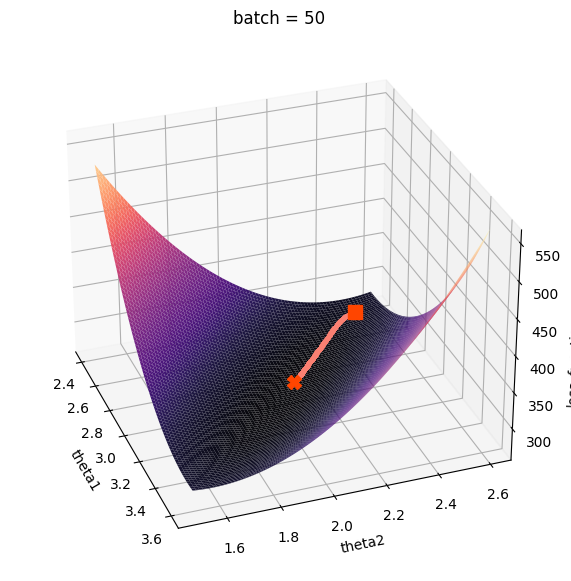

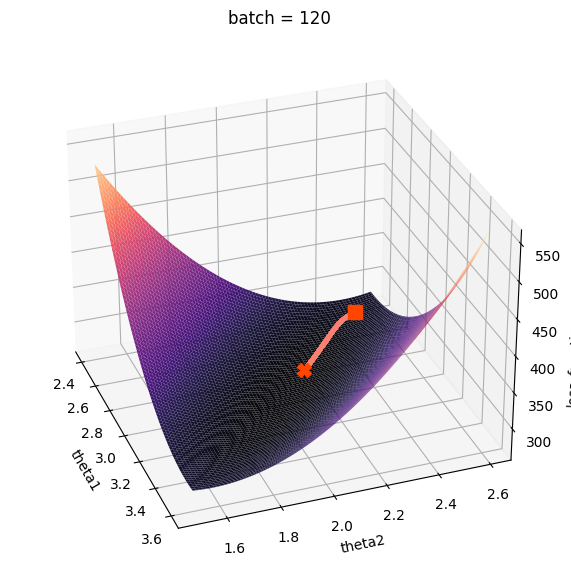

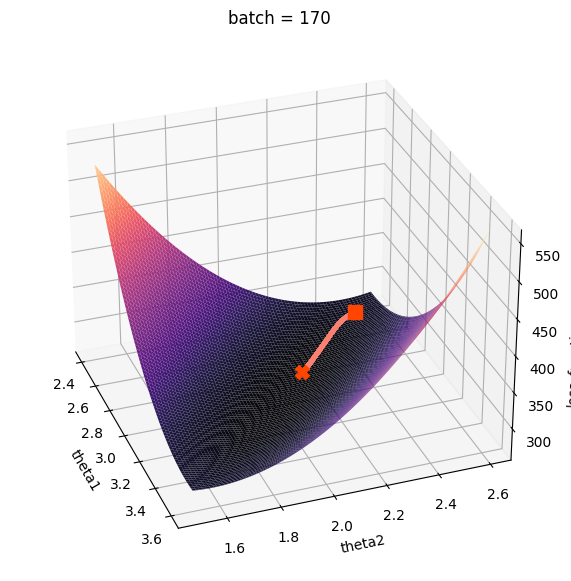

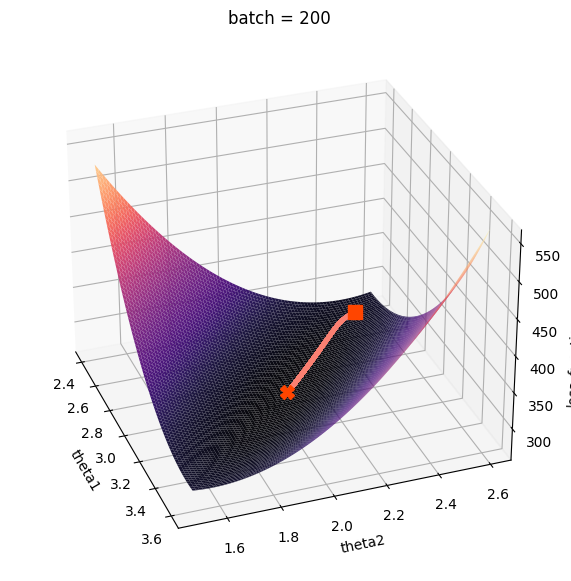

In [122]:
def draw_3d_function_theta(left_limit_x, right_Limit_x, left_limit_y, right_Limit_y, points, azim, dist, elev, orig_X, orig_Y, name=""):
    t1 = np.linspace(left_limit_x, right_Limit_x, 1000)
    t2 = np.linspace(left_limit_y, right_Limit_y, 1000)
    X, Y = np.meshgrid(t1, t2)
    Z = X.copy()
    for i in range(len(X)):
        for j in range(len(X[i])):
            Z[i][j] = loss_function(orig_X, orig_Y, np.array([X[i][j], Y[i][j]]))
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, Z, cmap = 'magma',
                    alpha=0.97, rstride=12, cstride=12, zorder=1) # draw function surface
    X = [p[0] for p in points]
    Y = [p[1] for p in points]
    Z = [loss_function(orig_X, orig_Y, np.array([p[0], p[1]])) for p in points]
    ax.plot(X, Y, Z,'.', color='salmon', zorder=4, markersize=4) # draw dots of gradient_descent
    ax.plot(X, Y, Z, linewidth=0.5, color='salmon', zorder=4, label=name) # draw lines beetwen dots
    ax.plot(X[0], Y[0], Z[0], 's', color='orangered', zorder=4, markersize=10) # draw entry point
    ax.plot(X[-1], Y[-1], Z[-1], 'X', color='orangered', zorder=4, markersize=10) # draw end point
    ax.set_title(name)
    ax.set_xlabel('theta1')
    ax.set_ylabel('theta2')
    ax.set_zlabel('loss_function')
    ax.azim = azim
    ax.dist = dist
    ax.elev = elev
    plt.show()

def func(x):
    return 2 * x + 3

def generate_sample(step=0.01, total=200):
    x = 0
    for i in range(total):
        yield func(x) + np.random.uniform(-1, 1) * np.random.uniform(1, 3)
        x += step

data_first_task = pd.DataFrame(columns=["Cost function (less is better)", "Iterations", "Time (sec)", "Memory (KiB)"])

TOTAL = 200
STEP = 0.01
INITIAL_THETA = [2.5, 2.5]
lr = 0.007
eps = 1e-5

X = np.arange(0, TOTAL * STEP, STEP, dtype=np.float64)
Y = np.array([y for y in generate_sample(STEP, TOTAL)], dtype=np.float64)

A = np.empty((TOTAL, 2), dtype=np.float64)
A[:, 0] = 1
A[:, 1] = X

tmp = profile(lambda: stochastic_descent(A, Y, INITIAL_THETA, lr=lr, eps=eps), "1_theta_stochastic")
theta_stochastic = tmp["pt"]
data_first_task.loc["stochastic_descent"] = [tmp["cost"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: minibatch_descent(A, Y, INITIAL_THETA, batch_size=5, lr=lr, eps=eps), "1_theta_minibatch5")
theta_minibatch5 = tmp["pt"]
data_first_task.loc["theta_minibatch5"] = [tmp["cost"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: minibatch_descent(A, Y, INITIAL_THETA, batch_size=50, lr=lr, eps=eps), "1_theta_minibatch50")
theta_minibatch50 = tmp["pt"]
data_first_task.loc["theta_minibatch50"] = [tmp["cost"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: minibatch_descent(A, Y, INITIAL_THETA, batch_size=120, lr=lr, eps=eps), "1_theta_minibatch120")
theta_minibatch120 = tmp["pt"]
data_first_task.loc["theta_minibatch120"] = [tmp["cost"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: minibatch_descent(A, Y, INITIAL_THETA, batch_size=170, lr=lr, eps=eps), "1_theta_minibatch170")
theta_minibatch170 = tmp["pt"]
data_first_task.loc["theta_minibatch170"] = [tmp["cost"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: batch_descent(A, Y, INITIAL_THETA, lr=lr, eps=eps), "1_theta_batch")
theta_batch = tmp["pt"]
data_first_task.loc["theta_batch"] = [tmp["cost"], tmp["iter"], tmp["time"], tmp["mem"]]

####Count avg
# avg_st = [0, 0, 0, 0]
# avg_5 = [0, 0, 0, 0]
# avg_50 = [0, 0, 0, 0]
# avg_120 = [0, 0, 0, 0]
# avg_170 = [0, 0, 0, 0]
# avg_th = [0, 0, 0, 0]


# def add_avg(arr, res):
#     avg_st1 = arr
#     avg_st1[0] += res["cost"]
#     avg_st1[1] += res["iter"]
#     avg_st1[2] += res["time"]
#     avg_st1[3] += res["mem"]
#     return avg_st1

# sz = 15
# for i in range(sz) :
#     tmp = profile(lambda: stochastic_descent(A, Y, INITIAL_THETA, lr=lr, eps=eps), "1_theta_stochastic")
#     avg_st = add_avg(avg_st, tmp)

#     tmp = profile(lambda: minibatch_descent(A, Y, INITIAL_THETA, batch_size=5, lr=lr, eps=eps), "1_theta_minibatch5")
#     avg_5 = add_avg(avg_5, tmp)

#     tmp = profile(lambda: minibatch_descent(A, Y, INITIAL_THETA, batch_size=50, lr=lr, eps=eps), "1_theta_minibatch50")
#     avg_50 = add_avg(avg_50, tmp)

#     tmp = profile(lambda: minibatch_descent(A, Y, INITIAL_THETA, batch_size=120, lr=lr, eps=eps), "1_theta_minibatch120")
#     avg_120 = add_avg(avg_120, tmp)

#     tmp = profile(lambda: minibatch_descent(A, Y, INITIAL_THETA, batch_size=170, lr=lr, eps=eps), "1_theta_minibatch170")
#     avg_170 = add_avg(avg_170, tmp)

#     tmp = profile(lambda: batch_descent(A, Y, INITIAL_THETA, lr=lr, eps=eps), "1_theta_batch")
#     avg_th = add_avg(avg_th, tmp)

# data_first_task.loc["stochastic_descent"] = [avg_st[0]/sz, avg_st[1]/sz, avg_st[2]/sz, avg_st[3]/sz]
# data_first_task.loc["theta_minibatch5"] = [avg_5[0]/sz, avg_5[1]/sz, avg_5[2]/sz, avg_5[3]/sz]
# data_first_task.loc["theta_minibatch50"] = [avg_50[0]/sz, avg_50[1]/sz, avg_50[2]/sz, avg_50[3]/sz]
# data_first_task.loc["theta_minibatch120"] = [avg_120[0]/sz, avg_120[1]/sz, avg_120[2]/sz, avg_120[3]/sz]
# data_first_task.loc["theta_minibatch170"] = [avg_170[0]/sz, avg_170[1]/sz, avg_170[2]/sz, avg_170[3]/sz]
# data_first_task.loc["theta_batch"] = [avg_th[0]/sz, avg_th[1]/sz, avg_th[2]/sz, avg_th[3]/sz]
####End count avg

def function(x, theta):
    return theta[0] + theta[1] * x

colors = ['g', 'y', 'r']
data = [theta_stochastic[-1], theta_minibatch5[-1], theta_batch[-1]]
labels = ['SGD', 'Minibatch GD', 'GD']

f,axs = plt.subplots(1, 3, figsize=(22, 6), sharex=True, sharey=True)
f.suptitle("Graphs of functions found using different variations of GD")
for i,ax in enumerate(axs):
  axs[i].plot(X, Y, 'o', color='salmon', markersize=3)
  axs[i].plot(X, [function(p, data[i]) for p in X], '-', color=colors[i], markersize=4, label=labels[i])
  axs[i].set_xlabel("x")
  axs[i].set_ylabel("y")
  axs[i].legend(loc="upper left")

plt.show()

draw_3d_function_theta(2.4, 3.6, 1.5, 2.6, theta_stochastic, -20, 10, 30, A, Y, name="batch = 1")
draw_3d_function_theta(2.4, 3.6, 1.5, 2.6, theta_minibatch5, -20, 10, 30, A, Y, name="batch = 5")
draw_3d_function_theta(2.4, 3.6, 1.5, 2.6, theta_minibatch50, -20, 10, 30, A, Y, name="batch = 50")
draw_3d_function_theta(2.4, 3.6, 1.5, 2.6, theta_minibatch120, -20, 10, 30, A, Y, name="batch = 120")
draw_3d_function_theta(2.4, 3.6, 1.5, 2.6, theta_minibatch170, -20, 10, 30, A, Y, name="batch = 170")
draw_3d_function_theta(2.4, 3.6, 1.5, 2.6, theta_batch, -20, 10, 30, A, Y, name="batch = 200")

In [61]:
data_first_task # avg of 15, ne lez' blyat' debil suka ebaniy

Cost function (less is better)   Iterations  Time (sec)  \
stochastic_descent                      319.415274  8650.666667    0.340800   
theta_minibatch5                        317.439677  5556.133333    1.154667   
theta_minibatch50                       317.982982  1268.800000    1.489667   
theta_minibatch120                      316.823095  1432.666667    3.893333   
theta_minibatch170                      316.001632  1680.533333    6.335800   
theta_batch                             315.285025  3962.000000   13.507000   

                    Memory (KiB)  
stochastic_descent   1157.318359  
theta_minibatch5      699.073177  
theta_minibatch50     164.114714  
theta_minibatch120    181.564128  
theta_minibatch170    212.457878  
theta_batch           495.507747

# 2 пункт

## SGD with learning rate scheduling

In [123]:
def exp_lr(epoch, initial_lr):
  k = 0.00001
  learning_rate = initial_lr * exp(-k*epoch)
  return learning_rate


def stochastic_descent_with_lr_scheduling(X, Y, coefficients, lr=0.1, eps=1e-4):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(X, Y, theta)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps:
        learning_rate = exp_lr(epoch, lr)
        previous_cost = current_cost
        i = np.random.randint(0, len(Y))
        derivatives = [0] * len(theta)
        for j in range(len(theta)):
            derivatives[j] = (Y[i] - X[i]@theta) * X[i][j]
        theta[0] += learning_rate * derivatives[0]
        theta[1] += learning_rate * derivatives[1]
        current_cost = loss_function(X, Y, theta)
        epoch += 1
    snap = tracemalloc.take_snapshot()
    print(current_cost, epoch, "sgd_scheduling_cost", "epoch_count")
    return {'th' : theta, 'cost' : current_cost, 'iter' : epoch, 'snap' : snap}

## Testing

297.1355172147077 15269 sgd_scheduling_cost epoch_count
Total allocated size: 4.7 KiB
320.95013627455364 3291 sgd_cost epoch_count
Total allocated size: 443.5 KiB


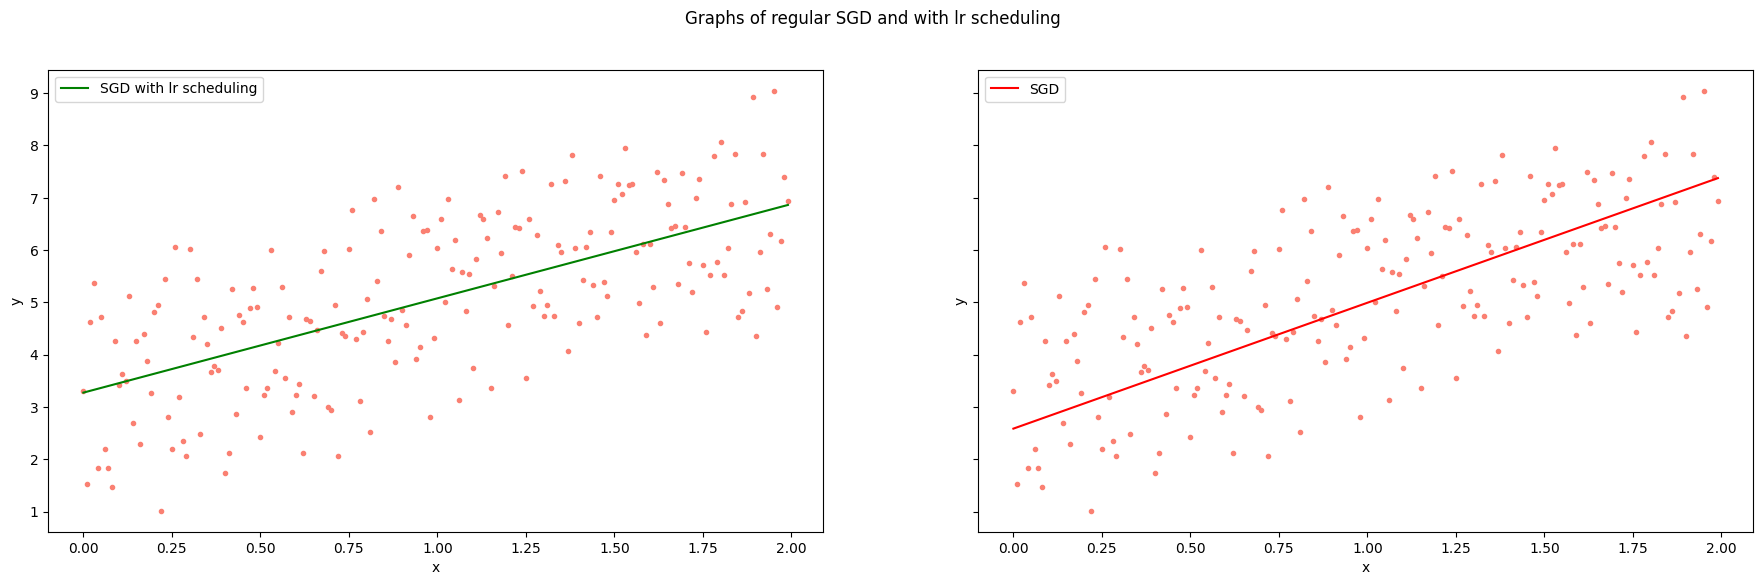

In [141]:
data_second_task = pd.DataFrame(columns=["Cost function (less is better)", "Iterations", "Time (sec)", "Memory (KiB)"])

def func(x):
    return 2 * x + 3

def generate_sample(step=0.01, total=200):
    x = 0
    for i in range(total):
        yield func(x) + np.random.uniform(-1, 1) * np.random.uniform(1, 3)
        x += step

TOTAL = 200
STEP = 0.01
INITIAL_THETA = [9, 14]
lr = 0.003
eps = 1e-6

X = np.arange(0, TOTAL * STEP, STEP, dtype=np.float64)
Y = np.array([y for y in generate_sample(STEP, TOTAL)], dtype=np.float64)

A = np.empty((TOTAL, 2), dtype=np.float64)
A[:, 0] = 1
A[:, 1] = X

tmp = profile(lambda: stochastic_descent_with_lr_scheduling(A, Y, INITIAL_THETA, lr=lr, eps=eps), "2_theta_stochastic_with_lr_scheduling")
theta_stochastic_with_lr_scheduling = tmp["th"]
data_second_task.loc["theta_stochastic_with_lr_scheduling"] = [tmp["cost"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: stochastic_descent(A, Y, INITIAL_THETA, lr=lr, eps=eps), "2_theta_stochastic")
theta_stochastic = tmp["pt"]
data_second_task.loc["theta_stochastic"] = [tmp["cost"], tmp["iter"], tmp["time"], tmp["mem"]]

####Count avg
# def add_avg(arr, res):
#     avg_st1 = arr
#     avg_st1[0] += res["cost"]
#     avg_st1[1] += res["iter"]
#     avg_st1[2] += res["time"]
#     avg_st1[3] += res["mem"]
#     return avg_st1

# avg1 = [0, 0, 0, 0]
# avg2 = [0, 0, 0, 0]

# sz = 50
# for i in range(sz):
#     tmp = profile(lambda: stochastic_descent_with_lr_scheduling(A, Y, INITIAL_THETA, lr=lr, eps=eps), "2_theta_stochastic_with_lr_scheduling")
#     avg1 = add_avg(avg1, tmp)
#     tmp = profile(lambda: stochastic_descent(A, Y, INITIAL_THETA, lr=lr, eps=eps), "2_theta_stochastic")
#     avg2 = add_avg(avg2, tmp)
# theta_stochastic = tmp["pt"]
# data_second_task.loc["theta_stochastic_with_lr_scheduling"] = [avg1[0]/sz, avg1[1]/sz, avg1[2]/sz, avg1[3]/sz]
# data_second_task.loc["theta_stochastic"] = [avg2[0]/sz, avg2[1]/sz, avg2[2]/sz, avg2[3]/sz]
#####End Count avg

def function(x, theta):
    return theta[0] + theta[1] * x

colors = ['g', 'r']
data = [theta_stochastic_with_lr_scheduling, theta_stochastic[-1]]
labels = ['SGD with lr scheduling', 'SGD']

f,axs = plt.subplots(1, 2, figsize=(22, 6), sharex=True, sharey=True)
f.suptitle("Graphs of regular SGD and with lr scheduling")
for i,ax in enumerate(axs):
    axs[i].plot(X, Y, 'o', color='salmon', markersize=3)
    axs[i].plot(X, [function(p, data[i]) for p in X], '-', color=colors[i], markersize=4, label=labels[i])
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("y")
    axs[i].legend(loc="upper left")

plt.show()

In [76]:
data_second_task # avg of 50

Cost function (less is better)  \
theta_stochastic_with_lr_scheduling                      280.099439   
theta_stochastic                                         280.287495   

                                     Iterations  Time (sec)  Memory (KiB)  
theta_stochastic_with_lr_scheduling    16570.24     0.61600      3.702422  
theta_stochastic                       19152.70     0.69562      3.317031

# 3 пункт

## Utils

In [142]:
def check_points(point1, point2, eps=1e-6):
    for i in range(len(point1)):
      if abs(point1[i] - point2[i]) > eps:
        return True
    return False

def draw_3d_function(left_limit, right_Limit, points, azim, dist, elev, function, name=""):
    t = np.linspace(left_limit, right_Limit, 1000)
    X, Y = np.meshgrid(t, t)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    my_col = cm.cool(function(X, Y)/np.amax(function(X, Y))) # color of surface
    ax.plot_surface(X, Y, function(X, Y), facecolors = my_col,
                    alpha=0.8, rstride=12, cstride=12, zorder=1) # draw function surface
    X = [p[0] for p in points]
    Y = [p[1] for p in points]
    Z = [function(p[0], p[1]) for p in points]
    ax.plot(X, Y, Z,'.', color='salmon', zorder=4, markersize=4) # draw dots of gradient_descent
    ax.plot(X, Y, Z, linewidth=0.5, color='salmon', zorder=4, label=name) # draw lines beetwen dots
    ax.plot(X[0], Y[0], Z[0], 's', color='orangered', zorder=4, markersize=10) # draw entry point
    ax.plot(X[-1], Y[-1], Z[-1], 'X', color='orangered', zorder=4, markersize=10) # draw end point
    ax.set_title(name)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.azim = azim
    ax.dist = dist
    ax.elev = elev
    plt.show()
  
def draw_lines_of_level(points, function, name=""):
    t = np.linspace(-7, 7, 100)
    X, Y = np.meshgrid(t, t)
    plt.plot([p[0] for p in points], [p[1] for p in points], 'o-', color='salmon', zorder=4, markersize=4) # draw dots of gradient_descent
    plt.plot([p[0] for p in points], [p[1] for p in points], linewidth=0.5, color='salmon', zorder=4, label=name) # draw lines beetwen dots
    plt.plot(points[0][0], points[0][1], 's', color='orangered', zorder=4, markersize=10) # draw entry point
    plt.plot(points[-1][0], points[-1][1], 'X', color='orangered', zorder=4, markersize=10) # draw end point
    plt.contour(X, Y, function(X, Y), levels=np.unique(sorted([function(p[0], p[1]) for p in points])))
    plt.title(name)
    plt.show()

## GD with Momentum

In [143]:
def gradient_descent_with_momentum(x, grad_f, lr=0.1, alpha=0.9):
    theta = x.copy()
    points = [x]
    g = np.array([0, 0], dtype=np.float64)
    epoch = 1
    while True:
        g = alpha * g + (1 - alpha) * lr * np.array(grad_f(theta[0], theta[1]))
        theta = theta - g
        points.append(theta)
        if not check_points(points[-2], points[-1]):
          break
        epoch += 1
    snap = tracemalloc.take_snapshot()
    print(theta, epoch, "momentum")
    return {'th' : theta, 'pt' : points, 'iter' : epoch, 'snap' : snap}

## GD with Nesterov

In [144]:
def gradient_descent_with_nesterov(x, grad_f, lr=0.1, alpha=0.9):
    theta = x.copy()
    points = [x]
    g = np.array([0, 0], dtype=np.float64)
    epoch = 1
    while True:
        theta -= alpha * g
        g = alpha * g + (1 - alpha) * lr * np.array(grad_f(theta[0], theta[1]))
        theta = theta - g
        points.append(theta)
        if not check_points(points[-2], points[-1]):
          break
        epoch += 1

    snap = tracemalloc.take_snapshot()
    print(theta, epoch, "nesterov")
    return {'th' : theta, 'pt' : points, 'iter' : epoch, 'snap' : snap}

## GD with AdaGrad

In [145]:
def gradient_descent_with_adagrad(x, grad_f, lr=2):
    theta = x.copy()
    points = [x]
    g = np.array([0, 0], dtype=np.float64)
    epoch = 1
    while True:
        grad = np.array(grad_f(theta[0], theta[1]))
        g += grad ** 2
        theta = theta - lr / (g ** 0.5) * grad
        points.append(theta)
        if not check_points(points[-2], points[-1]):
            break
        epoch += 1

    snap = tracemalloc.take_snapshot()
    print(theta, epoch, "adagrad")
    return {'th' : theta, 'pt' : points, 'iter' : epoch, 'snap' : snap}

## GD with RMSProp

In [146]:
def gradient_descent_with_rmsprop(x, grad_f, lr=2, gamma=0.9):
    theta = x.copy()
    points = [x]
    g = np.array([0, 0], dtype=np.float64)
    epoch = 1
    while True:
        grad = np.array(grad_f(theta[0], theta[1]))
        g = gamma * g + (1 - gamma) * grad ** 2
        theta = theta - lr / (g ** 0.5 + 1e-6) * grad
        points.append(theta)
        if len(points) > 2 and (points[-1] == points[-3]).all():
          break
        if not check_points(points[-2], points[-1]):
          break
        epoch += 1

    snap = tracemalloc.take_snapshot()
    print(theta, epoch, "rmsprop")
    return {'th' : theta, 'pt' : points, 'iter' : epoch, 'snap' : snap}

## GD with Adam

In [147]:
def gradient_descent_with_adam(x, grad_f, lr=0.1, b1=0.9, b2=0.999):
    theta = x.copy()
    points = [x]
    m = np.array([0, 0], dtype=np.float64)
    v = np.array([0, 0], dtype=np.float64)
    epoch = 1
    while True:
        grad = np.array(grad_f(theta[0], theta[1]))
        m = b1 * m + (1 - b1) * grad
        v = b2 * v + (1 - b2) * grad ** 2
        mm = m / (1 - b1 ** epoch)
        vv = v / (1 - b2 ** epoch)
        theta = theta - lr / (vv ** 0.5) * mm
        points.append(theta)
        if not check_points(points[-2], points[-1]):
          break
        epoch += 1

    snap = tracemalloc.take_snapshot()
    print(theta, epoch, "adam")
    return {'th' : theta, 'pt' : points, 'iter' : epoch, 'snap' : snap}

## Testing

[-2.80511786  3.1313125 ] 18 original
Total allocated size: 21.6 KiB
[3.00000785 1.99999412] 250 momentum
Total allocated size: 37.2 KiB
[2.99999744 1.99997819] 226 nesterov
Total allocated size: 33.9 KiB
[-2.80513337  3.13131278] 172 adagrad
Total allocated size: 27.0 KiB
[-2.85402563  3.07994021] 637 rmsprop
Total allocated size: 89.7 KiB
[2.99999821 2.00000577] 261 adam
Total allocated size: 39.1 KiB


/tmp/ipykernel_1761/2313186383.py:27: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = dist


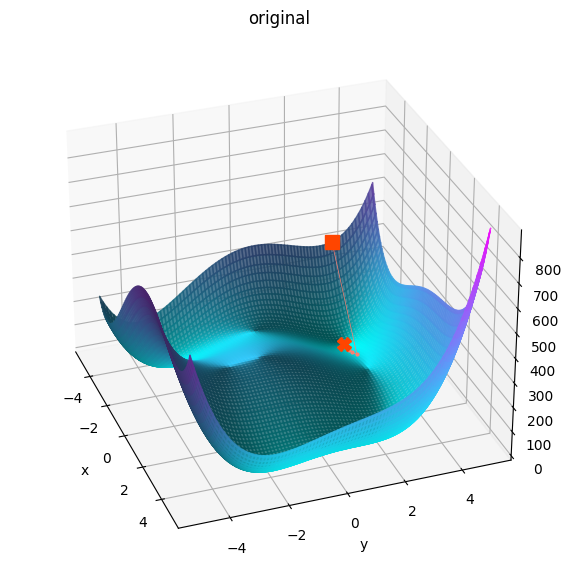

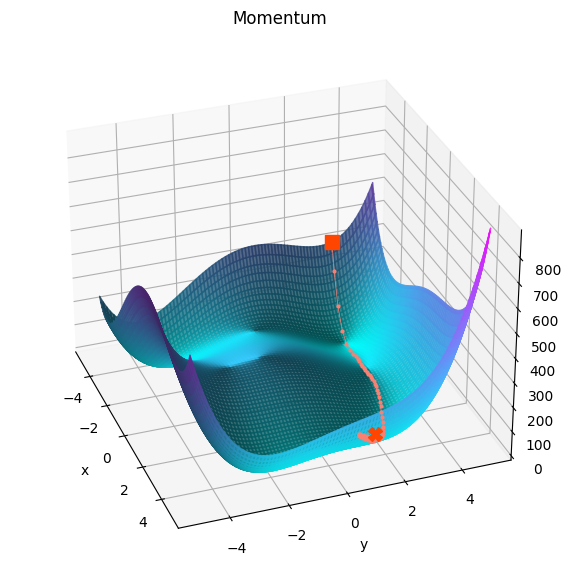

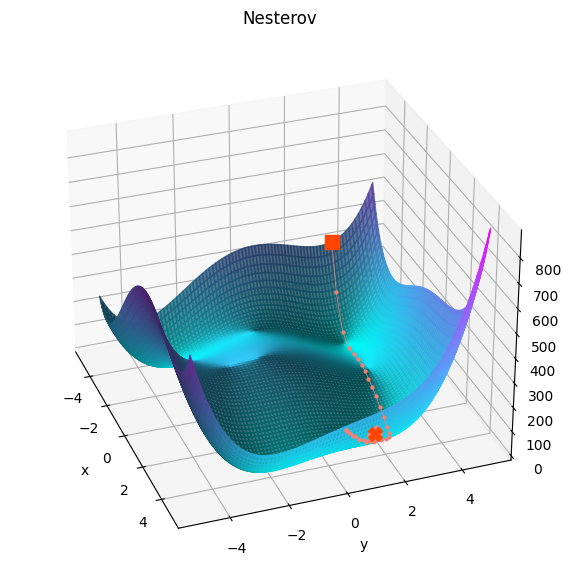

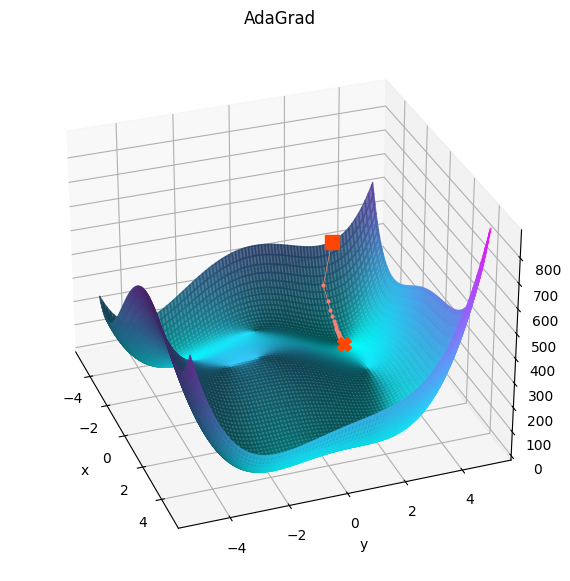

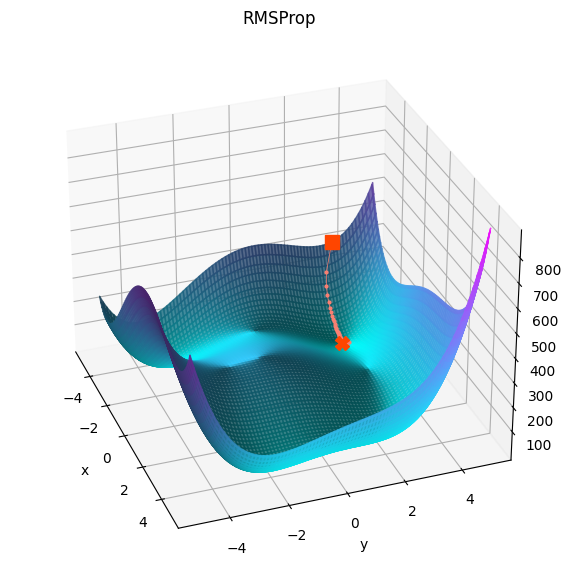

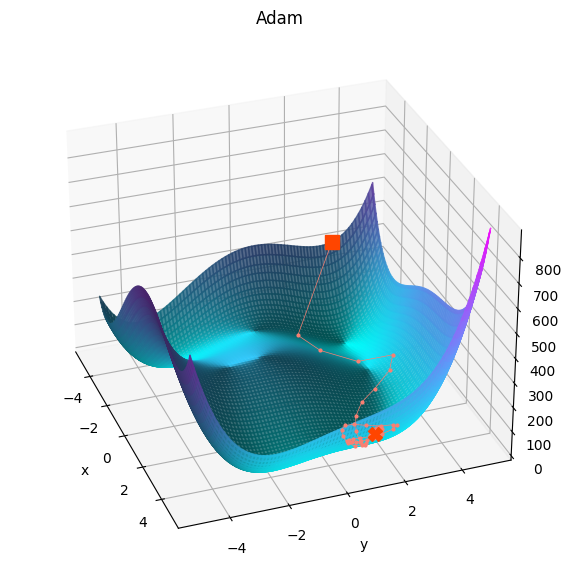

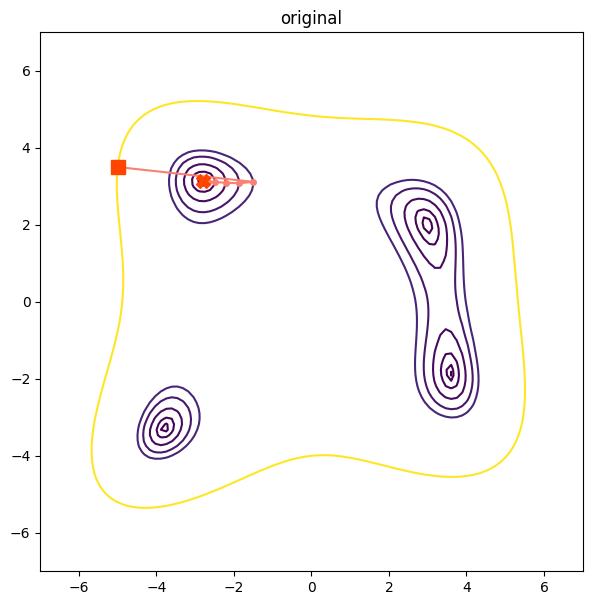

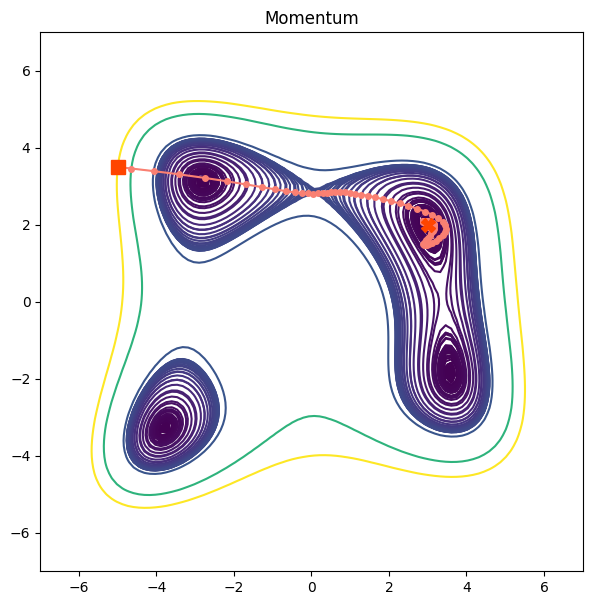

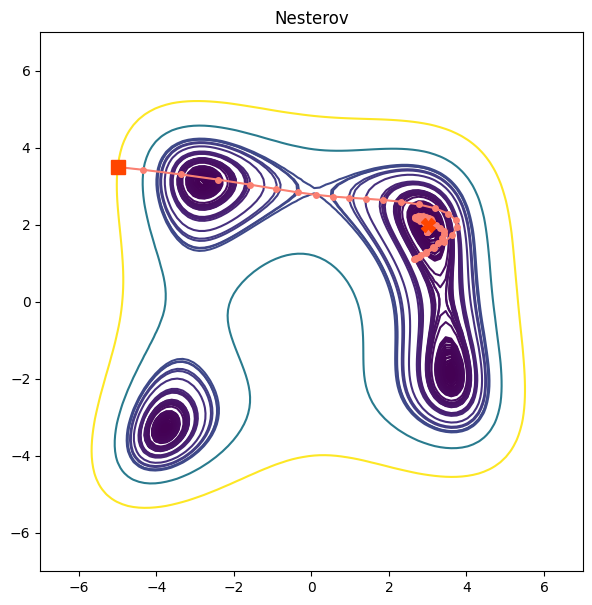

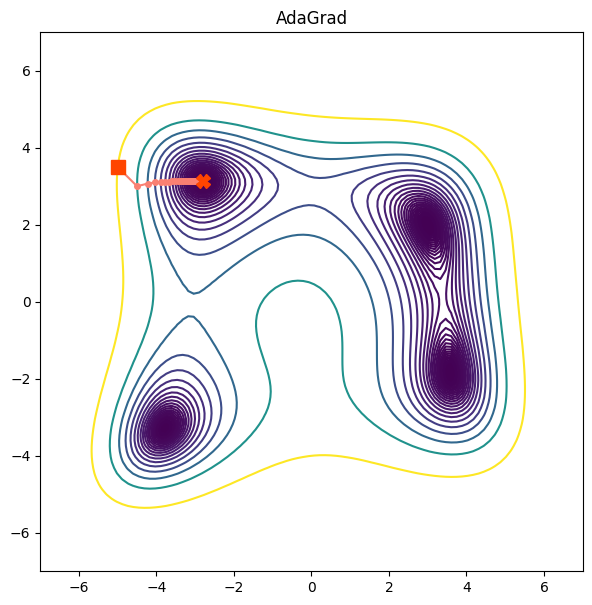

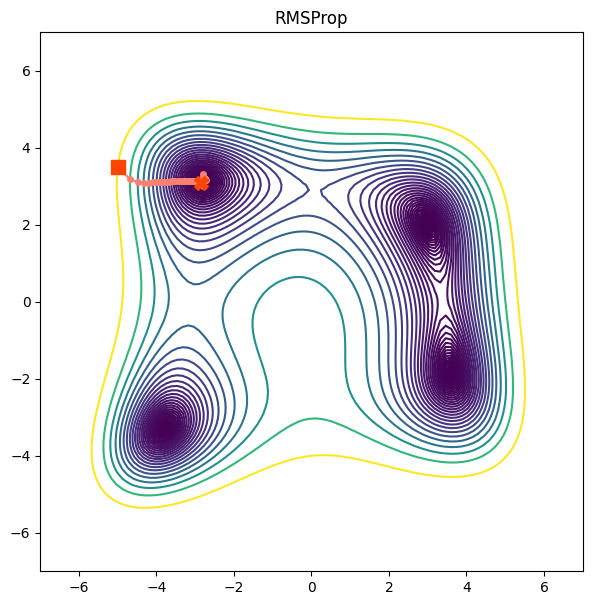

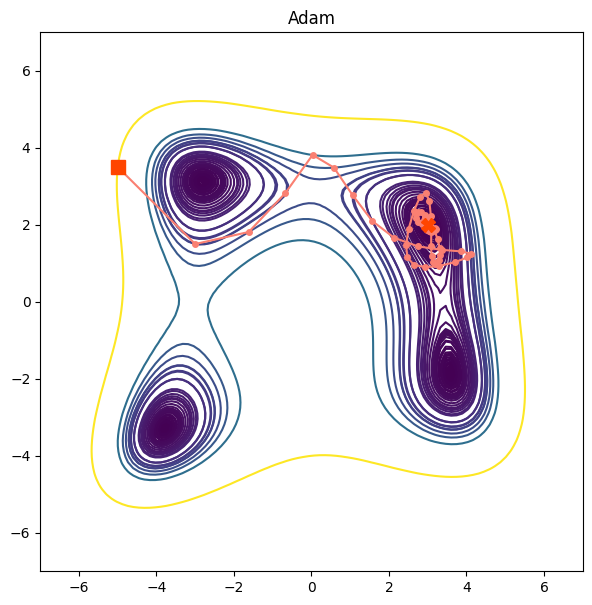

In [148]:
data_third_task = pd.DataFrame(columns=["Theta", "Iterations", "Time (sec)", "Memory (KiB)"])

# def f(x, y):
    # return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2
# def grad(x, y):
    # return [2 * (200 * x ** 3 - 200 * x * y + x - 1), -200 * (x ** 2 - y)]

def f(x, y):
    return (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2 # f1
def grad(x, y):
    return [2 * (2 * x * (x ** 2 + y - 11) + x + y ** 2 - 7), 2 * (x ** 2 + 2 * y * (x + y ** 2 - 7) + y - 11)]

# def f(x, y):
    # return (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2 # f2
# def grad(x, y):
    # return [10 * x + 8 * y - 34, 8 * x + 10 * y - 38]

def gradient_descent(x, grad_f, lr=0.1):
    theta = x.copy()
    points = [x]
    epoch = 1
    while True:
        theta = theta - lr * np.array(grad_f(theta[0], theta[1]))
        points.append(theta)
        if not check_points(points[-2], points[-1]):
          break
        epoch += 1
    print(theta, epoch, "original")

    snap = tracemalloc.take_snapshot()
    return {'th' : theta, 'pt' : points, 'iter' : epoch, 'snap' : snap}

x = [-5, 3.5]


tmp = profile(lambda: gradient_descent(x, grad, lr=0.01), "3_gradient_descent")
points_gd = tmp["pt"]
data_third_task.loc["gradient_descent"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: gradient_descent_with_momentum(x, grad, lr=0.01), "3_gradient_descent_with_momentum")
points_with_momentum = tmp["pt"]
data_third_task.loc["gradient_descent_with_momentum"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: gradient_descent_with_nesterov(x, grad, lr=0.01), "3_gradient_descent_with_nesterov")
points_with_nesterov = tmp["pt"]
data_third_task.loc["gradient_descent_with_nesterov"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: gradient_descent_with_adagrad(x, grad, lr=0.5), "3_gradient_descent_with_adagrad")
points_with_adagrad = tmp["pt"]
data_third_task.loc["gradient_descent_with_adagrad"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: gradient_descent_with_rmsprop(x, grad, lr=0.1), "3_gradient_descent_with_rmsprop")
points_with_rmsprop = tmp["pt"]
data_third_task.loc["gradient_descent_with_rmsprop"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

tmp = profile(lambda: gradient_descent_with_adam(x, grad, lr=2), "3_gradient_descent_with_adam")
points_with_adam = tmp["pt"]
data_third_task.loc["gradient_descent_with_adam"] = [tmp["th"], tmp["iter"], tmp["time"], tmp["mem"]]

### Count avg
# def add_avg(arr, res):
#     avg_st1 = arr
#     avg_st1[0] += res["th"]
#     avg_st1[1] += res["iter"]
#     avg_st1[2] += res["time"]
#     avg_st1[3] += res["mem"]
#     return avg_st1

# avg1 = [0, 0, 0, 0]
# avg2 = [0, 0, 0, 0]
# avg3 = [0, 0, 0, 0]
# avg4 = [0, 0, 0, 0]
# avg5 = [0, 0, 0, 0]
# avg6 = [0, 0, 0, 0]

# sz = 200
# for i in range(sz):
#     tmp = profile(lambda: gradient_descent(x, grad, lr=0.01), "3_gradient_descent")
#     avg1 = add_avg(avg1, tmp)

#     tmp = profile(lambda: gradient_descent_with_momentum(x, grad, lr=0.01), "3_gradient_descent_with_momentum")
#     avg2 = add_avg(avg2, tmp)

#     tmp = profile(lambda: gradient_descent_with_nesterov(x, grad, lr=0.01), "3_gradient_descent_with_nesterov")
#     avg3 = add_avg(avg3, tmp)

#     tmp = profile(lambda: gradient_descent_with_adagrad(x, grad, lr=0.5), "3_gradient_descent_with_adagrad")
#     avg4 = add_avg(avg4, tmp)

#     tmp = profile(lambda: gradient_descent_with_rmsprop(x, grad, lr=0.1), "3_gradient_descent_with_rmsprop")
#     avg5 = add_avg(avg5, tmp)

#     tmp = profile(lambda: gradient_descent_with_adam(x, grad, lr=2), "3_gradient_descent_with_adam")
#     avg6 = add_avg(avg6, tmp)

# data_third_task.loc["gradient_descent"] = [avg1[0]/sz, avg1[1]/sz, avg1[2]/sz, avg1[3]/sz]
# data_third_task.loc["gradient_descent_with_momentum"] = [avg2[0]/sz, avg2[1]/sz, avg2[2]/sz, avg2[3]/sz]
# data_third_task.loc["gradient_descent_with_nesterov"] = [avg3[0]/sz, avg3[1]/sz, avg3[2]/sz, avg3[3]/sz]
# data_third_task.loc["gradient_descent_with_adagrad"] = [avg4[0]/sz, avg4[1]/sz, avg4[2]/sz, avg4[3]/sz]
# data_third_task.loc["gradient_descent_with_rmsprop"] = [avg5[0]/sz, avg5[1]/sz, avg5[2]/sz, avg5[3]/sz]
# data_third_task.loc["gradient_descent_with_adam"] = [avg6[0]/sz, avg6[1]/sz, avg6[2]/sz, avg6[3]/sz]

### End count avg

plt.rcParams["figure.figsize"] = (7, 7)
draw_3d_function(-5, 5, points_gd, -20, 10, 30, f, name="original")
draw_3d_function(-5, 5, points_with_momentum, -20, 10, 30, f, name="Momentum")
draw_3d_function(-5, 5, points_with_nesterov, -20, 10, 30, f, name="Nesterov")
draw_3d_function(-5, 5, points_with_adagrad, -20, 10, 30, f, name="AdaGrad")
draw_3d_function(-5, 5, points_with_rmsprop, -20, 10, 30, f, name="RMSProp")
draw_3d_function(-5, 5, points_with_adam, -20, 10, 30, f, name="Adam")
draw_lines_of_level(points_gd, f, name="original")
draw_lines_of_level(points_with_momentum, f, name="Momentum")
draw_lines_of_level(points_with_nesterov, f, name="Nesterov")
draw_lines_of_level(points_with_adagrad, f, name="AdaGrad")
draw_lines_of_level(points_with_rmsprop, f, name="RMSProp")
draw_lines_of_level(points_with_adam, f, name="Adam")

In [93]:
data_third_task # avg of 200 function 1

Theta  \
gradient_descent                 [-2.8051178596723467, 3.131312499244587]   
gradient_descent_with_momentum   [3.0000078485537767, 1.9999941175198626]   
gradient_descent_with_nesterov   [2.9999974377652077, 1.9999781946356336]   
gradient_descent_with_adagrad      [-2.805133370861159, 3.13131278182959]   
gradient_descent_with_rmsprop   [-2.8540256277695533, 3.0799402107992453]   
gradient_descent_with_adam       [2.9999982094760727, 2.0000057685332275]   

                                Iterations  Time (sec)  Memory (KiB)  
gradient_descent                      18.0    0.001245     19.353101  
gradient_descent_with_momentum       250.0    0.006320     36.261855  
gradient_descent_with_nesterov       226.0    0.006375     32.982627  
gradient_descent_with_adagrad        172.0    0.004910     26.112925  
gradient_descent_with_rmsprop        637.0    0.023890     88.941582  
gradient_descent_with_adam           261.0    0.011025     38.247905

In [90]:
data_third_task # avg of 200 function 2

Theta  \
gradient_descent                [0.9999514460024767, 3.0000485539975346]   
gradient_descent_with_momentum   [0.9999638073868395, 3.000036192280439]   
gradient_descent_with_nesterov   [0.9999832098980056, 3.000000753738002]   
gradient_descent_with_adagrad    [0.9998897799368865, 3.000103253041334]   
gradient_descent_with_rmsprop   [1.0499999444444434, 3.0499999444444486]   
gradient_descent_with_adam      [1.0000034870636818, 3.0000001282411857]   

                                Iterations  Time (sec)  Memory (KiB)  
gradient_descent                     550.0    0.008475     90.449199  
gradient_descent_with_momentum       440.0    0.008540     61.558193  
gradient_descent_with_nesterov       239.0    0.005310     34.879121  
gradient_descent_with_adagrad       1159.0    0.023895    157.830381  
gradient_descent_with_rmsprop        771.0    0.025380    107.226963  
gradient_descent_with_adam           268.0    0.009610     39.422222

## Maybe will be helpful

In [ ]:
def stochastic_descent_with_momentum(X, Y, coefficients, lr=0.1, eps=1e-4, alpha=0.01):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_theta = np.array(coefficients.copy(), dtype=np.float64)
    delta_theta = np.zeros(2, dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(X, Y, theta)
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        delta_theta[0] = abs(previous_theta[0] - theta[0])
        delta_theta[1] = abs(previous_theta[1] - theta[1])
        i = np.random.randint(0, len(Y))
        derivatives = [0] * len(theta)
        for j in range(len(theta)):
            derivatives[j] = (Y[i] - X[i]@theta) * X[i][j]
        previous_theta[0] = theta[0]
        previous_theta[1] = theta[1]
        theta[0] += (lr * derivatives[0] + alpha * delta_theta[0])
        theta[1] += (lr * derivatives[1] + alpha * delta_theta[1])
        current_cost = loss_function(X, Y, theta)
    return theta

def stochastic_descent_with_nesterov(X, Y, coefficients, lr=0.1, eps=1e-4, alpha=0.01):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_theta = np.array(coefficients.copy(), dtype=np.float64)
    delta_theta = np.zeros(2, dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(X, Y, theta)
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        delta_theta[0] = abs(previous_theta[0] - theta[0])
        delta_theta[1] = abs(previous_theta[1] - theta[1])
        theta[0] += alpha * delta_theta[0]
        theta[1] += alpha * delta_theta[0]
        i = np.random.randint(0, len(Y))
        derivatives = [0] * len(theta)
        for j in range(len(theta)):
            derivatives[j] = (Y[i] - X[i]@theta) * X[i][j]
        previous_theta[0] = theta[0]
        previous_theta[1] = theta[1]
        theta[0] += lr * derivatives[0]
        theta[1] += lr * derivatives[1]
        current_cost = loss_function(X, Y, theta)
    return theta

def stochastic_descent_with_adagrad(X, Y, coefficients, lr=0.1, eps=1e-4):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    # previous_gradients = []
    previous_cost = 10 ** 6
    current_cost = loss_function(X, Y, theta)
    g = [0, 0]
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        i = np.random.randint(0, len(Y))
        derivatives = [0] * len(theta)
        for j in range(len(theta)):
            derivatives[j] = (Y[i] - X[i]@theta) * X[i][j]
        g[0] += derivatives[0] ** 2
        g[1] += derivatives[1] ** 2
        # previous_gradients.append(derivatives)
        # g = [0, 0]
        # for i in range(len(g)):
        #   for j in range(len(previous_gradients)):
        #     g[i] += previous_gradients[j][i] ** 2
        theta[0] += lr / g[0] ** 0.5 * derivatives[0]
        theta[1] += lr / g[1] ** 0.5 * derivatives[1]
        current_cost = loss_function(X, Y, theta)
    return theta

def stochastic_descent_with_rmsprop(X, Y, coefficients, lr=0.1, eps=1e-4, gamma=0.9):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(X, Y, theta)
    g = [0, 0]
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        i = np.random.randint(0, len(Y))
        derivatives = [0] * len(theta)
        for j in range(len(theta)):
            derivatives[j] = (Y[i] - X[i]@theta) * X[i][j]
        g[0] = gamma * g[0] + (1 - gamma) * derivatives[0] ** 2
        g[1] = gamma * g[1] + (1 - gamma) * derivatives[1] ** 2
        theta[0] += lr / g[0] ** 0.5 * derivatives[0]
        theta[1] += lr / g[1] ** 0.5 * derivatives[1]
        current_cost = loss_function(X, Y, theta)
    return theta

def stochastic_descent_with_adam(X, Y, coefficients, lr=0.1, eps=1e-4, b1=0.9, b2=0.999):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(X, Y, theta)
    m = [0, 0]
    v = [0, 0]
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        i = np.random.randint(0, len(Y))
        derivatives = [0] * len(theta)
        for j in range(len(theta)):
            derivatives[j] = (Y[i] - X[i]@theta) * X[i][j]
        if m[0] == 0 and m[1] == 0:
          m[0] = derivatives[0]
          m[1] = derivatives[1]
          # m[0] = m[0] / (1 - b1)
          # m[1] = m[1] / (1 - b1)
          v[0] = derivatives[0] ** 2
          v[1] = derivatives[1] ** 2
          # v[0] = v[0] / (1 - b2)
          # v[1] = v[1] / (1 - b2)
        m[0] = b1 * m[0] + (1 - b1) * derivatives[0]
        m[1] = b1 * m[1] + (1 - b1) * derivatives[1]
        # m[0] = m[0] / (1 - b1)
        # m[1] = m[1] / (1 - b1)
        v[0] = b2 * v[0] + (1 - b2) * derivatives[0] ** 2
        v[1] = b2 * v[1] + (1 - b2) * derivatives[1] ** 2
        # v[0] = v[0] / (1 - b2)
        # v[1] = v[1] / (1 - b2)
        # print(derivatives[0], m[0], v[0])
        theta[0] += lr / (v[0] ** 0.5) * m[0]
        theta[1] += lr / (v[1] ** 0.5) * m[1]
        current_cost = loss_function(X, Y, theta)
        print(current_cost, theta)
    return theta


def func(x):
    return 2 * x + 3

def generate_sample(step=0.1, total=400):
    x = 0
    for i in range(total):
        yield func(x) + np.random.uniform(-1, 1) * np.random.uniform(1, 8)
        x += step

TOTAL = 200
STEP = 0.01
INITIAL_THETA = [20, 20]

X = np.arange(0, TOTAL * STEP, STEP, dtype=np.float64)
Y = np.array([y for y in generate_sample(STEP, TOTAL)], dtype=np.float64)

A = np.empty((TOTAL, 2), dtype=np.float64)
A[:, 0] = 1
A[:, 1] = X

theta_stochastic_with_nesterov = stochastic_descent_with_nesterov(A, Y, INITIAL_THETA, lr=0.001, eps=1e-6)
theta_stochastic_with_momentum = stochastic_descent_with_momentum(A, Y, INITIAL_THETA, lr=0.001, eps=1e-6)
theta_stochastic_with_adagrad = stochastic_descent_with_adagrad(A, Y, INITIAL_THETA, lr=0.3, eps=1e-6)
theta_stochastic_with_rmsprop = stochastic_descent_with_rmsprop(A, Y, INITIAL_THETA, lr=0.03, eps=1e-6)
theta_stochastic_with_adam = stochastic_descent_with_adam(A, Y, INITIAL_THETA, lr=0.01, eps=1e-6)
theta_stochastic = stochastic_descent(A, Y, INITIAL_THETA, lr=0.001, eps=1e-6)

def function(x, theta):
    return theta[0] + theta[1] * x

colors = ['red', 'black', 'lime', 'lawngreen', 'fuchsia', 'aqua']
data = [theta_stochastic, theta_stochastic_with_nesterov, theta_stochastic_with_momentum, theta_stochastic_with_adagrad, theta_stochastic_with_rmsprop, theta_stochastic_with_adam]
labels = ['SGD', 'SGD with nesterov', 'SGD with momentum', 'SGD with adagrad', 'SGD with RMSProp', 'SGD with adam']

f,axs = plt.subplots(2, 3, figsize=(20, 10), sharex=True, sharey=True)
f.suptitle("Graphs of regular SGD and with momentum")
for i,ax in enumerate(axs):
  for j in range(3):
    axs[i][j].plot(X, Y, 'o', color='salmon', markersize=3)
    axs[i][j].plot(X, [function(p, data[i * 3 + j]) for p in X], '-', color=colors[i * 3 + j], markersize=4, label=labels[i * 3 + j])
    axs[i][j].plot(X, [func(p) for p in X], '-', color='b', zorder=4, markersize=4, label='original')
    axs[i][j].set_xlabel("x")
    axs[i][j].set_ylabel("y")
    axs[i][j].legend(loc="upper left")

plt.show()

KeyboardInterrupt: ignored

# Доп

## Polynomial regression

4.792845474863354 original


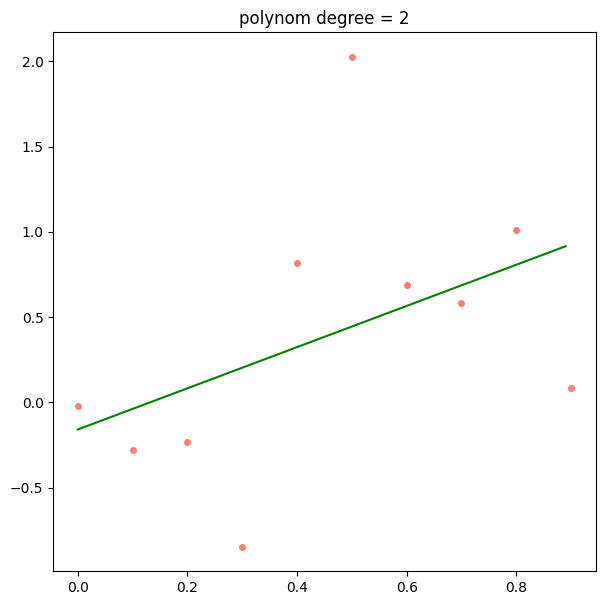

4.122184520006754 original


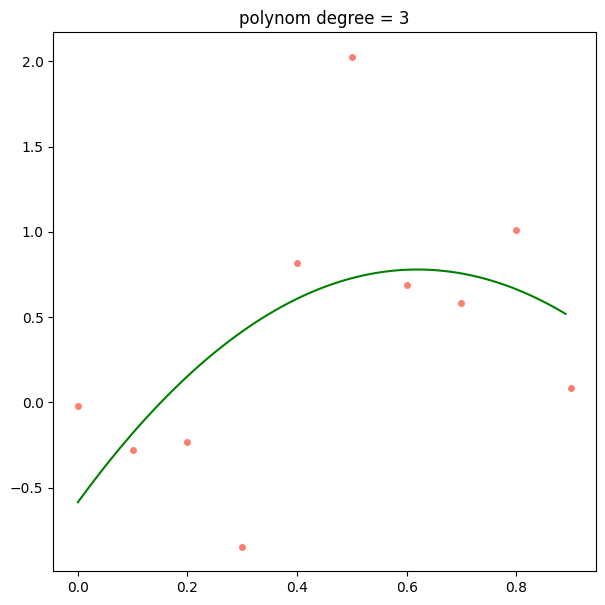

2.658357322236548 original


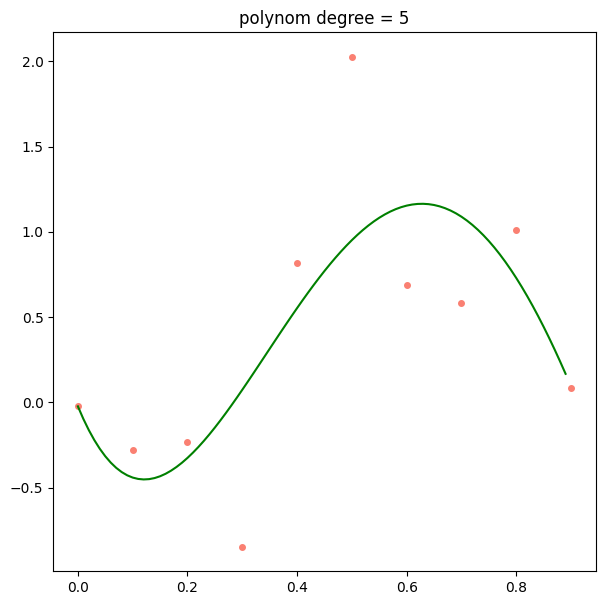

2.039573556691913 original


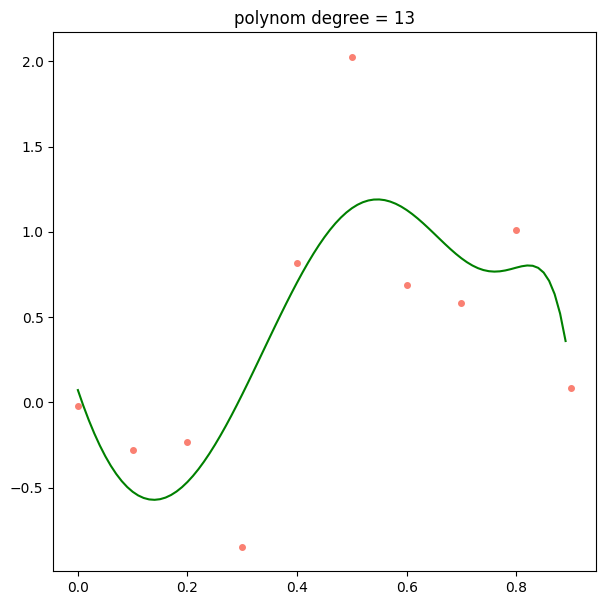

1.6245945867876144 original


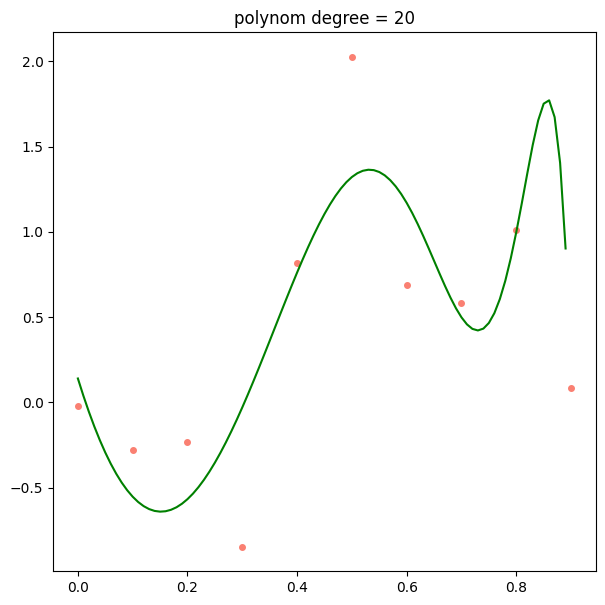

In [551]:
def gd_with_adam(X, Y, coefficients, lr=0.1, eps=1e-4, b1=0.9, b2=0.999):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = loss_function(X, Y, theta)
    m = np.zeros(len(theta), dtype=np.float64)
    v = np.zeros(len(theta), dtype=np.float64)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ += (Y[i] - X[i]@theta) * X[i][j]
            derivatives[j] = summ
        m = b1 * m + (1 - b1) * derivatives
        v = b2 * v + (1 - b2) * derivatives ** 2
        mm = m / (1 - b1 ** epoch)
        vv = v / (1 - b2 ** epoch)
        theta = theta + lr / (vv ** 0.5) * mm
        current_cost = loss_function(X, Y, theta)
        epoch += 1
    print(current_cost, "original")
    return theta


TOTAL = 10
STEP = 0.1
FROM = 0
INITIAL_THETA = [[1, 1], [1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
lr = 1
eps = 1e-6

result = [0] * len(INITIAL_THETA)

def function(x, theta):
    result = 0
    for i in range(len(theta)):
      result += theta[i] * x ** i
    return result

X_new = np.arange(0, 0.9, 0.01, dtype=np.float64)

for i in range(len(INITIAL_THETA)):
  X = np.arange(FROM, TOTAL * STEP + FROM, STEP, dtype=np.float64)
  Y = np.array([-0.02303106, -0.27686492, -0.22946492, -0.8456339, 0.81891949, 2.02615791, 0.68671234, 0.58596677, 1.01167922, 0.08661992], dtype=np.float64)

  A = np.empty((TOTAL, len(INITIAL_THETA[i])), dtype=np.float64)
  for j in range(len(INITIAL_THETA[i])):
    A[:, j] = [x ** j for x in X]

  result[i] = stochastic_descent_with_adagrad(A, Y, INITIAL_THETA[i], lr=lr, eps=eps)
  plt.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  plt.plot(X_new, [function(p, result[i]) for p in X_new], '-', color='g', zorder=4, markersize=4)
  plt.title(f'polynom degree = {len(INITIAL_THETA[i])}')
  plt.show()

## L1 regularization

In [538]:
def l1_loss_function(X, Y, theta, alpha=0.001):
    return (Y - X@theta).T@(Y - X@theta) + alpha * np.sum(np.abs(theta))

def gd_with_adam_l1(X, Y, coefficients, lr=0.1, eps=1e-6, alpha=0.001, b1=0.9, b2=0.999):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = l1_loss_function(X, Y, theta, alpha)
    m = np.zeros(len(theta), dtype=np.float64)
    v = np.zeros(len(theta), dtype=np.float64)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ += (Y[i] - X[i]@theta) * X[i][j] - alpha * np.sign(theta[j])
            derivatives[j] = summ
        m = b1 * m + (1 - b1) * derivatives
        v = b2 * v + (1 - b2) * derivatives ** 2
        mm = m / (1 - b1 ** epoch)
        vv = v / (1 - b2 ** epoch)
        theta = theta + lr / (vv ** 0.5) * mm
        current_cost = l1_loss_function(X, Y, theta, alpha)
        epoch += 1
    print(current_cost, "l1")
    return theta

## L2 regularization

In [539]:
def l2_loss_function(X, Y, theta, alpha=0.001):
    return (Y - X@theta).T@(Y - X@theta) + alpha * np.sum(theta ** 2)

def gd_with_adam_l2(X, Y, coefficients, lr=0.1, eps=1e-4, alpha=0.0001, b1=0.9, b2=0.999):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = l2_loss_function(X, Y, theta, alpha)
    m = np.zeros(len(theta), dtype=np.float64)
    v = np.zeros(len(theta), dtype=np.float64)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ += (Y[i] - X[i]@theta) * X[i][j] - 2 * alpha * theta[j]
            derivatives[j] = summ
        m = b1 * m + (1 - b1) * derivatives
        v = b2 * v + (1 - b2) * derivatives ** 2
        mm = m / (1 - b1 ** epoch)
        vv = v / (1 - b2 ** epoch)
        theta = theta + lr / (vv ** 0.5) * mm
        current_cost = loss_function(X, Y, theta)
        epoch += 1
    print(current_cost, "l2")
    return theta

## Elastic regularization

In [543]:
def elastic_loss_function(X, Y, theta, alpha=0.001):
    return (Y - X@theta).T@(Y - X@theta) + alpha * np.sum(np.abs(theta)) + alpha * np.sum(theta ** 2)

def gd_with_adam_elastic(X, Y, coefficients, lr=0.1, eps=1e-4, alpha=0.0001, gamma=0.5, b1=0.9, b2=0.999):
    theta = np.array(coefficients.copy(), dtype=np.float64)
    previous_cost = 10 ** 6
    current_cost = elastic_loss_function(X, Y, theta, alpha)
    m = np.zeros(len(theta), dtype=np.float64)
    v = np.zeros(len(theta), dtype=np.float64)
    epoch = 1
    while np.abs(previous_cost - current_cost) > eps:
        previous_cost = current_cost
        derivatives = np.array([0] * len(theta), dtype=np.float64)
        for j in range(len(theta)):
            summ = 0
            for i in range(len(Y)):
                summ += (Y[i] - X[i]@theta) * X[i][j] - 2 * alpha * theta[j] - alpha * np.sign(theta[j])
            derivatives[j] = summ
        m = b1 * m + (1 - b1) * derivatives
        v = b2 * v + (1 - b2) * derivatives ** 2
        mm = m / (1 - b1 ** epoch)
        vv = v / (1 - b2 ** epoch)
        epoch += 1
        theta = theta + lr / (vv ** 0.5) * mm
        current_cost = elastic_loss_function(X, Y, theta, alpha)
    print(current_cost, "elastic")
    return theta

## Testing

1.2982586585386202 original
5.32959143663864 l1
2.7069942506991462 l2
4.721076275407091 elastic
1.800670740466051 gd
0.10467311820971166 gd_l1
0.8427047655842976 gd_l2
0.22776857018301266 gd_elastic


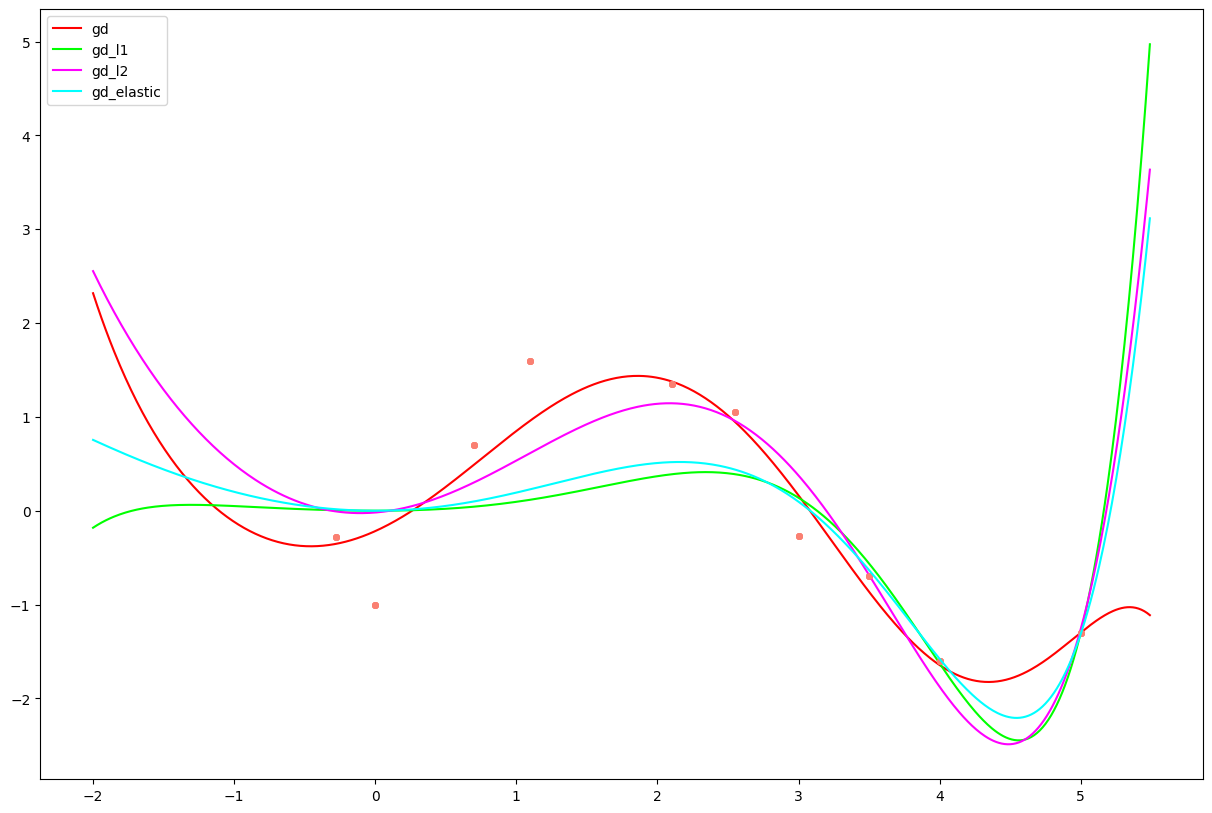

In [545]:
TOTAL = 10
STEP = 0.1
FROM = 0
INITIAL_THETA = [0, 1, 1, 0, 0, 0, 0, 0]
lr = 0.01
eps = 1e-7
alpha = 0.7

def function(x, theta):
    result = 0
    for i in range(len(theta)):
      result += theta[i] * x ** i
    return result

X = np.array([0, -0.27686492, 0.7, 1.1, 2.1, 2.55, 3, 3.5, 4, 5], dtype=np.float64)
Y = np.array([-1, -0.27686492, 0.7, 1.6, 1.35, 1.05, -0.27, -0.7, -1.6, -1.3], dtype=np.float64)

A = np.empty((TOTAL, len(INITIAL_THETA)), dtype=np.float64)
for j in range(len(INITIAL_THETA)):
  A[:, j] = [x ** j for x in X]

gd = gd_with_adam(A, Y, INITIAL_THETA, lr=lr, eps=eps)
gd_l1 = gd_with_adam_l1(A, Y, INITIAL_THETA, lr=lr, eps=eps, alpha=alpha)
gd_l2 = gd_with_adam_l2(A, Y, INITIAL_THETA, lr=lr, eps=eps, alpha=alpha)
gd_elastic = gd_with_adam_elastic(A, Y, INITIAL_THETA, lr=lr, eps=eps, alpha=alpha)

data = [gd, gd_l1, gd_l2, gd_elastic]
colors = ['red', 'lime', 'fuchsia', 'aqua']
labels = ['gd', 'gd_l1', 'gd_l2', 'gd_elastic']

fig, ax = plt.subplots()
X_new = np.arange(-2, 5.5, 0.01, dtype=np.float64)
for i in range(len(data)):
  ax.plot(X, Y, 'o', color='salmon', zorder=4, markersize=4)
  ax.plot(X_new, [function(p, data[i]) for p in X_new], '-', color=colors[i], zorder=4, markersize=4, label=labels[i])
  print(np.sum(np.abs(data[i])), labels[i])
ax.legend()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.show()
